# Concept-Driven Modeling: Disentangling Structural Drivers

**Project:** Concept-Driven Disentanglement for Interpretable SC-FC Coupling

**Paper Reference:** *A Concept-Driven Disentanglement Framework for Interpretable Graph Neural Networks in Structure-Function Coupling*

## Overview
In this notebook, we implement the **Concept-Driven Disentanglement Framework**. Unlike the "Black Box" baseline, this model is explicitly designed to separate the influence of distinct structural concepts on functional connectivity.

**Demonstration Concept: Normal vs. Outlier Connections**
We hypothesize that "outlier" edges (connections with unusually high or low streamline counts compared to the cohort) play a distinct role in shaping FC compared to "normal" edges.
* **Concept A (Normal):** Connections within 2 standard deviations of the cohort mean.
* **Concept B (Outlier):** Connections exceeding $\pm 2\sigma$ from the cohort mean.

**Architecture:**
An **Ensemble GNN** where:
1.  **Branch 1** sees *only* Normal edges.
2.  **Branch 2** sees *only* Outlier edges.
3.  **Fusion:** An MLP combines embeddings from both branches to predict FC.

In [1]:
import os
import torch

# 1. Force install PyTorch 2.8.0 with CUDA 12.6
# We use --upgrade --force-reinstall to overwrite whatever Colab loaded by default
!pip install torch==2.8.0+cu126 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126 --upgrade

# 2. Verify the version before proceeding
import torch
print(f"Successfully installed PyTorch version: {torch.__version__}")

# 3. Set environment variable for PyG (PyTorch Geometric) installation
# This tells pip explicitly which binary wheels to grab
os.environ['TORCH'] = "2.8.0+cu126"

Looking in indexes: https://download.pytorch.org/whl/cu126
  Using cached https://download.pytorch.org/whl/cu126/torchvision-0.24.1%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Using cached https://download.pytorch.org/whl/cu126/torchaudio-2.9.1%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.9 kB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
  Using cached https://download.pytorch.org/whl/cu126/torchvision-0.24.0%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
  Using cached https://download.pytorch.org/whl/cu126/torchaudio-2.9.0%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.9 kB)


In [2]:
!pip install torch_geometric

# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric-temporal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 1.0 MB/s eta 0:00:00


## 1. Concept Definition (Mask Generation)
We define a function `create_outlier_masks` that statistically identifies outlier connections across the cohort. This mask will determine which GNN branch processes which edge.

In [3]:
import numpy as np

def create_outlier_masks(sc_matrices, std_devs=2):
    """
    Creates a binary outlier mask for each subject based on cohort statistics.

    An outlier is defined as a connection outside the specified number of
    standard deviations from the cohort mean for that specific connection.

    Args:
        sc_matrices (np.ndarray): Array of SC matrices (num_subjects, num_nodes, num_nodes).
        std_devs (int): Number of standard deviations to define the outlier threshold.

    Returns:
        np.ndarray: An array of binary masks (num_subjects, num_nodes, num_nodes),
                    where 1 indicates an outlier and 0 indicates a normal connection.
    """
    # --- Calculate cohort-level statistics ---
    mean_connections = np.mean(sc_matrices, axis=0)
    std_connections = np.std(sc_matrices, axis=0)

    # --- Define the lower and upper bounds for "normal" connections ---
    lower_bound = mean_connections - (std_devs * std_connections)
    upper_bound = mean_connections + (std_devs * std_connections)
    # Ensure lower bound is not negative for structural connectivity
    np.maximum(lower_bound, 0, out=lower_bound)

    print(f"Calculated cohort thresholds based on {std_devs} standard deviations.")

    # --- Create a boolean mask for each subject ---
    # An outlier is a connection that is LESS THAN the lower bound OR GREATER THAN the upper bound.
    # This operation is vectorized for efficiency across all subjects at once.
    outlier_masks_bool = (sc_matrices < lower_bound) | (sc_matrices > upper_bound)

    # --- Convert the boolean array to an integer array (1s and 0s) ---
    outlier_masks_int = outlier_masks_bool.astype(int)

    # Optional: Print the average ratio of outliers for verification
    avg_outlier_ratio = np.mean(outlier_masks_int)
    print(f"Average proportion of outlier connections across all subjects: {avg_outlier_ratio:.2%}")

    return outlier_masks_int

## 2. Ensemble GNN Architecture
The model consists of two parallel `SingleGNN` branches.
* **Input:** The same node features ($X$) but distinct edge weights ($W_{normal}$ vs $W_{outlier}$).
* **Mechanism:** * `gnn_short` processes edges where `edge_length == 1` (Concept A).
    * `gnn_long` processes edges where `edge_length == 0` (Concept B).
    * *Note: The variable names `gnn_short/long` are generic placeholders for `gnn_concept_A/B`.*
* **Fusion:** Embeddings are concatenated and passed to a Dense Neural Network (DNN) for final FC prediction.

In [4]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch_scatter

class SingleGNN(nn.Module):
    """
    A single GNN module that processes graph data and outputs node embeddings.
    Unchanged from your original code.
    """
    def __init__(self, feature_num, hidden_conv_dims, output_embedding_dim, GNN_impl=GCNConv):
        super(SingleGNN, self).__init__()
        self.convs = nn.ModuleList()
        self.relus = nn.ModuleList()

        current_dim = feature_num
        for hidden_dim in hidden_conv_dims:
            self.convs.append(GNN_impl(current_dim, hidden_dim))
            self.relus.append(nn.ReLU())
            current_dim = hidden_dim

        self.convs.append(GNN_impl(current_dim, output_embedding_dim))
        self.relus.append(nn.ReLU())

    def forward(self, x, edge_index, edge_weight):
        for conv, relu in zip(self.convs, self.relus):
            x = relu(conv(x, edge_index, edge_weight))
        return x

class EnsembleGNNNet(nn.Module):
    """
    An ensemble of two GNNs for short and long-distance connections.
    """
    def __init__(self, feature_num=116,
                 gnn_intermediate_dims=[256],
                 gnn_output_embedding_dim=8,
                 dnn_hidden_dim=64,
                 GNN_impl=GCNConv):
        super(EnsembleGNNNet, self).__init__()

        self.gnn_short = SingleGNN(feature_num, gnn_intermediate_dims, gnn_output_embedding_dim, GNN_impl=GNN_impl)
        self.gnn_long = SingleGNN(feature_num, gnn_intermediate_dims, gnn_output_embedding_dim, GNN_impl=GNN_impl)

        mlp_input_dim = (gnn_output_embedding_dim * 2) * 2
        self.dnn = nn.Sequential(
            nn.Linear(mlp_input_dim, dnn_hidden_dim),
            nn.ReLU(),
            nn.Linear(dnn_hidden_dim, 1)
        )

    def forward(self, x, edge_index, edge_weight, edge_length, label_edge_index):
        """
        Forward pass for the EnsembleGNNNet.
        Now takes 'edge_length' as an argument.
        """
        # --- Preprocess edge_weight based on edge_length ---
        is_actual_edge = (edge_weight > 0).float()

        # GNN for short-distance connections
        edge_weight_first = torch.where(
            (edge_length == 1) & (is_actual_edge.bool()),
            edge_weight,
            torch.zeros_like(edge_weight)
        )

        # GNN for long-distance connections
        edge_weight_second = torch.where(
            (edge_length == 0) & (is_actual_edge.bool()),
            edge_weight,
            torch.zeros_like(edge_weight)
        )

        # --- Get node embeddings from each GNN ---
        x_embed_gnn_first = self.gnn_short(x, edge_index, edge_weight_first)
        x_embed_gnn_second = self.gnn_long(x, edge_index, edge_weight_second)

        x_combined_node_embeddings = torch.cat((x_embed_gnn_first, x_embed_gnn_second), dim=-1)

        # --- Prepare input for the final MLP ---
        source_nodes_combined_emb = x_combined_node_embeddings[label_edge_index[0]]
        target_nodes_combined_emb = x_combined_node_embeddings[label_edge_index[1]]

        mlp_input = torch.cat((source_nodes_combined_emb, target_nodes_combined_emb), dim=-1)

        out = self.dnn(mlp_input)
        return out, mlp_input

## 3. Data Preparation
We load the MICA-MICS dataset and inject the concept masks into the graph data object as `edge_length`.
* `edge_length = 1`: Indicates an "Outlier" connection.
* `edge_length = 0`: Indicates a "Normal" connection.

In [5]:
import torch
from torch_geometric.data import Data

def create_graph_from_sc(sc_matrix, fc_matrix, edge_length_matrix):
    """
    Creates a graph object from SC, FC, and edge length matrices.
    """
    num_nodes = sc_matrix.shape[0]

    # Node features: one-hot encodings
    x = torch.eye(num_nodes)

    edge_index = []
    edge_attr = []
    y = []
    edge_lengths = [] # New list to store edge lengths

    for i in range(num_nodes):
        for j in range(num_nodes):
            edge_index.append([i, j])
            edge_attr.append(sc_matrix[i, j])
            y.append(fc_matrix[i, j])
            edge_lengths.append(edge_length_matrix[i, j]) # Store the corresponding edge length


    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.float)
    edge_lengths = torch.tensor(edge_lengths, dtype=torch.float) # Convert to a tensor

    # Add edge_lengths as an attribute to the Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, edge_length=edge_lengths)
    return data

from torch_geometric.data import InMemoryDataset

class SCGraphDataset(InMemoryDataset):
    """
    A dataset of graphs, where each graph is created from SC, FC, and edge length data.
    """
    def __init__(self, dataset, transform=None):
        super().__init__('.', transform)
        # Now we pass 'sc', 'fc', and 'edge_length' to the graph creation function
        self.data_list = [
            create_graph_from_sc(item['sc'], item['fc'], item['edge_length']) for item in dataset
        ]

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

In [6]:
import copy
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader

fc = np.load('MICA_FC_data_100p.npy')
sc = np.load('MICA_SC_data_100p.npy')

# Normalize the sc and fc data
eps = 1e-8
SC_min = sc.min(axis=(1, 2), keepdims=True)  # Minimum value for each matrix
SC_max = sc.max(axis=(1, 2), keepdims=True)  # Maximum value for each matrix
sc = (sc - SC_min) / (SC_max - SC_min + eps)


FC_min = fc.min(axis=(1, 2), keepdims=True)  # Minimum value for each matrix
FC_max = fc.max(axis=(1, 2), keepdims=True)  # Maximum value for each matrix
fc = (fc - FC_min) / (FC_max - FC_min + eps)


edge_length_matrix = create_outlier_masks(sc, std_devs=2)

dataset = []
for i in range(50):
    sc_subject = sc[i]
    fc_subject = fc[i]
    dataset.append({
        "subject_id": i,
        "sc": sc_subject,
        "fc": fc_subject,
        "edge_length": edge_length_matrix[i]
    })


# Set seed
torch.random.manual_seed(42)

# Convert to Graph
graph_dataset = SCGraphDataset(dataset)

# Split full dataset
train_size = int(0.7 * len(graph_dataset))
test_size = len(graph_dataset) - train_size
train_dataset, test_dataset = random_split(graph_dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Calculated cohort thresholds based on 2 standard deviations.
Average proportion of outlier connections across all subjects: 4.73%


## 4. Training with Concept-Balancing
Since "Outlier" connections are rare (by definition), a standard MSE loss would bias the model to ignore them.
**Solution:** We implement a **Weighted MSE Loss**.
$$\mathcal{L}_{weighted} = \frac{1}{E} \sum_{e} w_e (y_e - \hat{y}_e)^2$$
Weights $w_e$ are inversely proportional to the frequency of the concept (Normal vs. Outlier) in the current batch, ensuring both concepts contribute equally to gradient updates.

Epoch 1 - New best model found!
Epoch 1 - Train Loss: 0.0197 - Test Loss: 0.0126
Epoch 2 - New best model found!
Epoch 2 - Train Loss: 0.0121 - Test Loss: 0.0126
Epoch 3 - Train Loss: 0.0116 - Test Loss: 0.0128
Epoch 4 - Train Loss: 0.0114 - Test Loss: 0.0126
Epoch 5 - New best model found!
Epoch 5 - Train Loss: 0.0114 - Test Loss: 0.0119
Epoch 6 - Train Loss: 0.0108 - Test Loss: 0.0124
Epoch 7 - Train Loss: 0.0108 - Test Loss: 0.0132
Epoch 8 - New best model found!
Epoch 8 - Train Loss: 0.0105 - Test Loss: 0.0117
Epoch 9 - Train Loss: 0.0104 - Test Loss: 0.0122
Epoch 10 - New best model found!
Epoch 10 - Train Loss: 0.0106 - Test Loss: 0.0115
Epoch 11 - New best model found!
Epoch 11 - Train Loss: 0.0097 - Test Loss: 0.0114
Epoch 12 - New best model found!
Epoch 12 - Train Loss: 0.0096 - Test Loss: 0.0113
Epoch 13 - New best model found!
Epoch 13 - Train Loss: 0.0098 - Test Loss: 0.0110
Epoch 14 - Train Loss: 0.0093 - Test Loss: 0.0115
Epoch 15 - Train Loss: 0.0089 - Test Loss: 0.0114

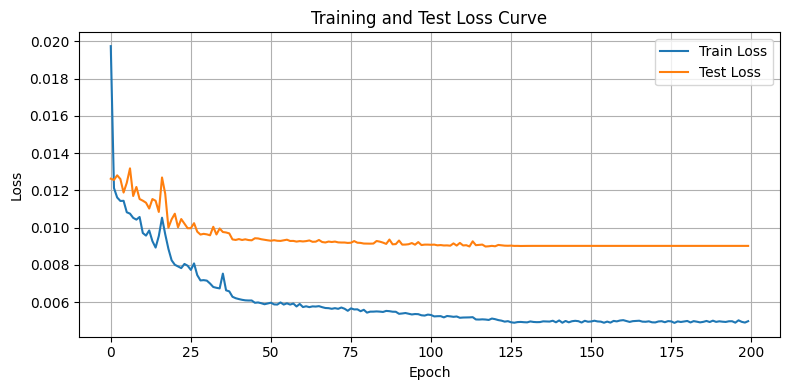

In [8]:
model = EnsembleGNNNet(
    feature_num=116,
    gnn_intermediate_dims=[32],
    gnn_output_embedding_dim=32,
    dnn_hidden_dim=128
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss(reduction='none')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=5
)

# Training
epochs = 200
train_losses = []
test_losses = []
best_test_loss = float('inf')
best_model_state = None

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        y_pred = model(data.x, data.edge_index, data.edge_attr, data.edge_length, data.edge_index)[0].squeeze()
        # loss = loss_fn(y_pred, data.y)
        # --- WEIGHTED LOSS CALCULATION ---
        unweighted_loss = loss_fn(y_pred, data.y)

        # 1. Dynamically count edges per concept in the current batch
        num_concept1 = torch.sum(data.edge_length == 1).float()
        num_edges = len(data.edge_length)
        num_concept2 = num_edges - num_concept1

        # 2. Calculate inverse frequency weights
        epsilon = 1e-6
        weight1 = num_edges / (2.0 * (num_concept1 + epsilon))
        weight2 = num_edges / (2.0 * (num_concept2 + epsilon))

        # 3. Assign weights to each edge's loss
        loss_weights = torch.ones_like(unweighted_loss)
        loss_weights[data.edge_length == 1] = weight1
        loss_weights[data.edge_length == 0] = weight2

        # 4. Calculate the final, weighted loss
        loss = (unweighted_loss * loss_weights).mean()
        # --- END OF MODIFICATION ---
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            y_pred = model(data.x, data.edge_index, data.edge_attr, data.edge_length, data.edge_index)[0].squeeze()
            # loss = loss_fn(y_pred, data.y)
            # --- WEIGHTED LOSS CALCULATION ---
            unweighted_loss = loss_fn(y_pred, data.y)

            # 1. Dynamically count edges per concept in the current batch
            num_concept1 = torch.sum(data.edge_length == 1).float()
            num_edges = len(data.edge_length)
            num_concept2 = num_edges - num_concept1

            # 2. Calculate inverse frequency weights
            epsilon = 1e-6
            weight1 = num_edges / (2.0 * (num_concept1 + epsilon))
            weight2 = num_edges / (2.0 * (num_concept2 + epsilon))

            # 3. Assign weights to each edge's loss
            loss_weights = torch.ones_like(unweighted_loss)
            loss_weights[data.edge_length == 1] = weight1
            loss_weights[data.edge_length == 0] = weight2

            # 4. Calculate the final, weighted loss
            loss = (unweighted_loss * loss_weights).mean()
            # --- END OF MODIFICATION ---
            total_test_loss += loss.item()
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # <<< MODIFICATION 2: UPDATE THE SCHEDULER >>>
    # The scheduler's step is called with the validation loss of the current epoch
    scheduler.step(avg_test_loss)
    # <<< END MODIFICATION 2 >>>

    # Save best model by validation loss
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"Epoch {epoch+1} - New best model found!")

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Test Loss: {avg_test_loss:.4f}")

# Restore best model
model.load_state_dict(best_model_state)

# save the best model
torch.save(model.state_dict(), 'GNN_OUTLIERvsNORMAL2STD_adjusted_116p.pth')

# Plot loss curves
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Performance Evaluation
We evaluate the Concept-Driven model using the same Pearson $r$ metrics as the baseline. For reproducibility, we also provided the original weights in `models/GNN_OUTLIERvsNORMAL2STD_adjusted_116p.pth`

In [9]:
from scipy.stats import pearsonr

def set_diagonal_inplace(pred, value=1.0):
    num_nodes = int(pred.size(0) ** 0.5)
    if pred.dim() == 1:  # flattened vector
        pred_matrix = pred.view(num_nodes, num_nodes)
        idx = torch.arange(num_nodes)
        pred_matrix[idx, idx] = value
    else:
        raise ValueError("Expected a 1D flattened FC vector.")

def calculate_pearson(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    r, _ = pearsonr(y_true, y_pred)
    return r

model = EnsembleGNNNet(
    feature_num=116,
    gnn_intermediate_dims=[32], # e.g., one intermediate layer of 128 units
    gnn_output_embedding_dim=32,
    dnn_hidden_dim=128
)
model.load_state_dict(torch.load('GNN_OUTLIERvsNORMAL2STD_adjusted_116p.pth'))
model.eval()

# Calculate group-avg pearson r
total_pearson = 0
iter = 0

sum_preds = None
sum_trues = None


with torch.no_grad():
    for data in test_loader:
        pred = model(data.x, data.edge_index, data.edge_attr, data.edge_length, data.edge_index)[0].squeeze()
        # make the diagonal 1 to avoid accounting it in pearson r
        set_diagonal_inplace(pred)
        true = data.y

        # Initialize accumulators with the shape of the first matrix
        if sum_preds is None:
            sum_preds = torch.zeros_like(pred.cpu())
            sum_trues = torch.zeros_like(true.cpu())

        sum_preds += pred.cpu()
        sum_trues += true.cpu()

        total_pearson += calculate_pearson(true, pred)
        iter += 1

# Compute element-wise averages (still 2x2)
avg_pred = sum_preds / iter
avg_true = sum_trues / iter

# Flatten both matrices to vectors
avg_pred_flat = avg_pred.flatten()
avg_true_flat = avg_true.flatten()

group_pearson = calculate_pearson(avg_true_flat, avg_pred_flat)

print("================================")
print(f"🎯 Group-Level Pearson r: {group_pearson}")
print("================================")

print("================================")
print(f"🎯 AVG. Individual Pearson r: {total_pearson / iter}")
print("================================")

🎯 Group-Level Pearson r: 0.9202068448066711
🎯 AVG. Individual Pearson r: 0.7371934652328491


## 6. Quantifying Concept Contribution (SHAP)
This is the key interpretability step. We use **SHAP (Shapley Additive Explanations)** to calculate the specific contribution of each branch to the final prediction.

**Methodology:**
1.  **DeepExplainer:** Computes SHAP values for the MLP inputs (which are the concatenated embeddings from the "Normal" and "Outlier" GNN branches).
2.  **Aggregation:** We sum the absolute SHAP values for all dimensions belonging to the "Normal" branch vs. the "Outlier" branch.
3.  **Ratio Metric:** This provides a quantitative ratio (e.g., *Normal connections contribute 3x more to FC prediction than Outlier connections*).

In [10]:
import shap

# --- Instantiate and "Train" the Model (for demonstration, we'll just initialize) ---
# In a real scenario, you would train this model on your SC/FC data.
model = EnsembleGNNNet(feature_num=116, gnn_intermediate_dims=[32], gnn_output_embedding_dim=32, dnn_hidden_dim=128)
model.load_state_dict(torch.load('GNN_OUTLIERvsNORMAL2STD_adjusted_116p.pth'))

# Set model to evaluation mode for consistent behavior (no dropout, etc.)
model.eval()

# --- Forward pass to get MLP input and output ---
subject_id = 0
with torch.no_grad():
    for data in test_loader:
        fc_predictions, mlp_inputs_for_shap = model(data.x, data.edge_index, data.edge_attr, data.edge_length, data.edge_index)
        if subject_id<10:
            subject_id += 1
        else:
            break

print(f"Shape of FC predictions: {fc_predictions.shape}") # Should be [num_label_edges, 1]
print(f"Shape of MLP inputs for SHAP: {mlp_inputs_for_shap.shape}") # Should be [num_label_edges, 32]

# --- SHAP Analysis ---

# 1. Create a background dataset for DeepExplainer
# It's good practice to use a subset of your training data's MLP inputs as background.
# For this demo, we'll just use a few samples from our generated mlp_inputs_for_shap.
# In a real scenario, this would come from your actual training data.
background_data = mlp_inputs_for_shap[:50].clone().detach().requires_grad_(True)

# 2. Initialize DeepExplainer
# The model to explain is `model.dnn` (the MLP part)
explainer = shap.DeepExplainer(model.dnn, background_data)

# 3. Compute SHAP values for the MLP inputs
# Ensure mlp_inputs_for_shap is a torch.Tensor with requires_grad=True
mlp_inputs_to_explain = mlp_inputs_for_shap.clone().detach().requires_grad_(True)
shap_values_mlp = explainer.shap_values(mlp_inputs_to_explain)

print(f"\nShape of SHAP values for MLP: {shap_values_mlp.shape}") # Should be [num_label_edges, 32]

Shape of FC predictions: torch.Size([13456, 1])
Shape of MLP inputs for SHAP: torch.Size([13456, 128])

Shape of SHAP values for MLP: (13456, 128, 1)


In [11]:
# Ensure shap_values_mlp is a numpy array for easier processing
if isinstance(shap_values_mlp, list):
    # DeepExplainer can return a list for multi-output models,
    # but our MLP has a single output (shape [num_label_edges, 1]),
    # so the list will contain one array of shape [num_label_edges, 32].
    shap_values_mlp = np.array(shap_values_mlp[0])
elif not isinstance(shap_values_mlp, np.ndarray):
     shap_values_mlp = shap_values_mlp.detach().cpu().numpy()


# Calculate the absolute SHAP values
abs_shap_values = np.abs(shap_values_mlp)

# Calculate the average of the absolute SHAP values along the first axis (samples)
# This gives us an average importance score for each of the 32 features
average_abs_shap_per_feature = np.mean(abs_shap_values, axis=0)

# print("\nAverage Absolute SHAP Value for each of the 32 MLP input dimensions:")
# print(average_abs_shap_per_feature)

average_abs_shap_values = average_abs_shap_per_feature.flatten()

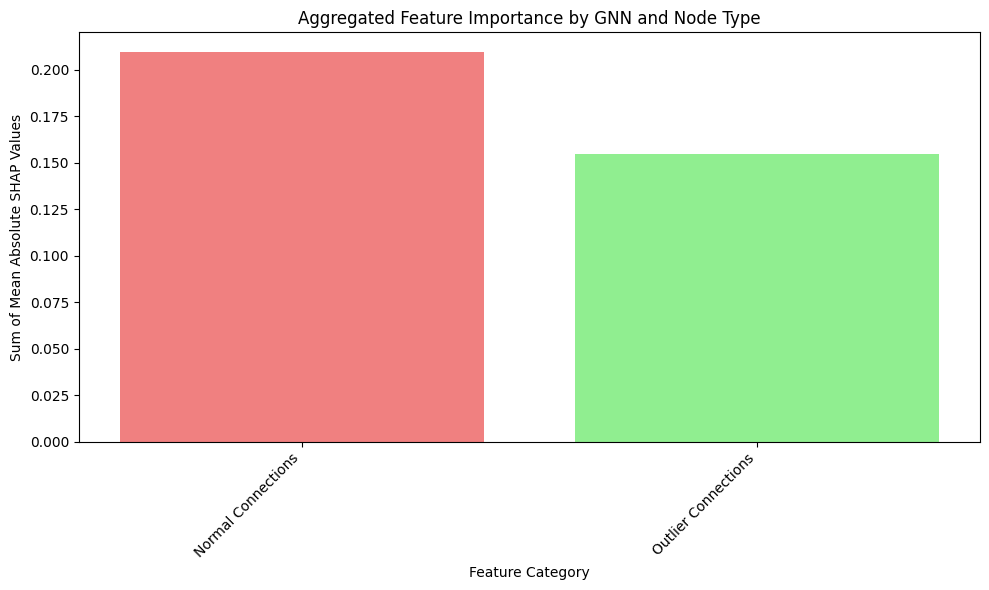


Aggregated Importance Values:
Normal Connections: 0.2095
Outlier Connections: 0.1545


In [12]:
# Define the output embedding dimension for each GNN
gnn_output_embedding_dim = 32

# Calculate the sum of mean absolute SHAP values for each category
# The order of features in `average_abs_shap_values` is:
# [Src_GNN1_Emb_0...7, Src_GNN2_Emb_0...7, Tgt_GNN1_Emb_0...7, Tgt_GNN2_Emb_0...7]

# Source GNN1 (Outlier Connections)
src_gnn1_importance = np.sum(average_abs_shap_values[0 : gnn_output_embedding_dim])

# Source GNN2 (Normal Connections)
src_gnn2_importance = np.sum(average_abs_shap_values[gnn_output_embedding_dim : 2 * gnn_output_embedding_dim])

# Target GNN1 (Outlier Connections)
tgt_gnn1_importance = np.sum(average_abs_shap_values[2 * gnn_output_embedding_dim : 3 * gnn_output_embedding_dim])

# Target GNN2 (Normal Connections)
tgt_gnn2_importance = np.sum(average_abs_shap_values[3 * gnn_output_embedding_dim : 4 * gnn_output_embedding_dim])

# Total normal Connections
total_outlier_connections = src_gnn1_importance + tgt_gnn1_importance

# Total outlier Connections
total_normal_connections = src_gnn2_importance + tgt_gnn2_importance

# Prepare data for the bar graph
categories = [
    "Normal Connections",
    "Outlier Connections"
]
importance_values = [
    total_normal_connections,
    total_outlier_connections
]

# Sort categories by importance for better visualization
sorted_categories_and_values = sorted(zip(categories, importance_values), key=lambda x: x[1], reverse=True)
sorted_categories = [item[0] for item in sorted_categories_and_values]
sorted_importance_values = [item[1] for item in sorted_categories_and_values]

# Create the bar graph
plt.figure(figsize=(10, 6)) # Adjust figure size as needed
plt.bar(sorted_categories, sorted_importance_values, color=['lightcoral', 'lightgreen'])
plt.xlabel("Feature Category")
plt.ylabel("Sum of Mean Absolute SHAP Values")
plt.title("Aggregated Feature Importance by GNN and Node Type")
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print("\nAggregated Importance Values:")
for category, value in sorted_categories_and_values:
    print(f"{category}: {value:.4f}")